# EDA on #happy from twitter and r/happy from reddit

### Getting Scraped Data from DB

In [1]:
from pymongo import MongoClient # for getting the scraped data

import re
import datetime
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer 
from collections import Counter

# for preprocess
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
def get_data():
    client = MongoClient("localhost", 27017)
    database = client["test"]
    
    l = []
    collection = database["twitterdb"]
    for item in collection.find():
        l.append(item)

    collection = database["redditdb"]
    for item in collection.find():
        date, time = str(item['datetime']).split()
        l.append({
            "_id":item["_id"]
            ,"date":date
            ,"time":time
            ,"text":item["text"]
        }) 
    return l

df = pd.DataFrame(get_data())
df.dropna(inplace=True)
df.head()

,_id,date,time,text
0,6266bc14d13f89484f3999c9,2022-04-25,18:10:06,great fairy cosplay(oot) I'm new but happy wit...
1,6266bc14d13f89484f3999ca,2022-04-25,18:09:37,Ohhh🤣! This is me. And this is my friend........
2,6266bc14d13f89484f3999cb,2022-04-25,18:07:28,#happy #PenguinDay Explorar para comprender y...
3,6266bc14d13f89484f3999cc,2022-04-25,18:06:35,hinagon_chan ゆうべは彼の部屋にお泊まり💓 #彼氏のいる生活 #のろけぐらむ❤︎...
4,6266bc14d13f89484f3999cd,2022-04-25,18:05:52,#happy #bankholidaymonday #buonventicinque 🍻 @...


In [3]:
df.describe()

,_id,date,time,text
count,18949,18949,18949,18949
unique,18949,59,16414,16164
top,6266bc14d13f89484f3999c9,2022-04-22,22:30:00,Welcome to /r/happy where we support people in...
freq,1,1594,8,859


In [4]:
# droping duplicates
# looks like we have duplicated tweets and comments probably some bot, re-posts or something else ...

df.drop_duplicates(subset=['text'],inplace=True)
df.describe()

,_id,date,time,text
count,16164,16164,16164,16164
unique,16164,59,14423,16164
top,6266bc14d13f89484f3999c9,2022-04-22,22:30:00,great fairy cosplay(oot) I'm new but happy wit...
freq,1,1452,8,1


## Date and time

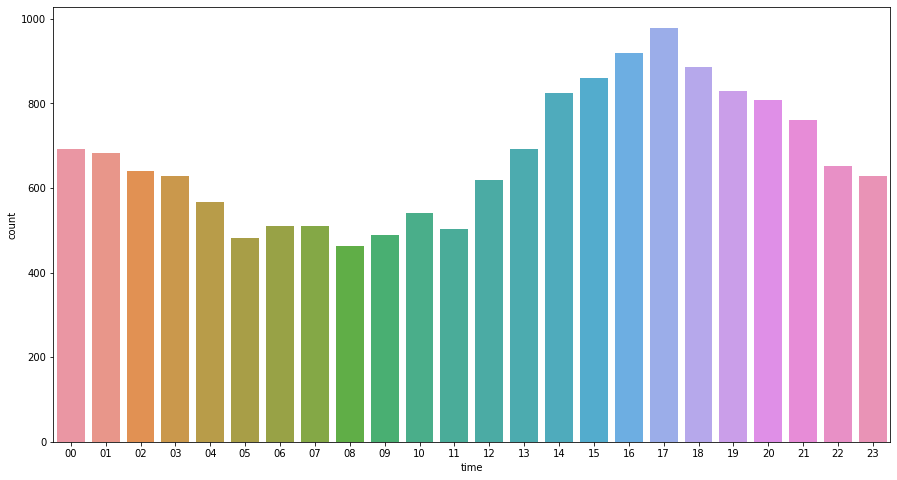

In [5]:
def plot_hours(df):
    hour_list=df["time"].apply(lambda x: re.search(r"^\d+", x).group())
    plt.figure(figsize = (15,8))
    sns.countplot(x=hour_list.sort_values())
    plt.show()
    
plot_hours(df)

In [6]:
# what years we have
print(set(df["date"].apply(lambda x: int(re.search(r"^\d+", x).group()))))

{2022}


In [7]:
# what months we have
print(set(df["date"].apply(lambda x: int(re.search(r"-\d+-", x).group().replace('-','')))))

{2, 3, 4}


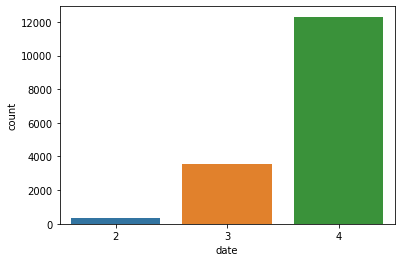

In [8]:
def plot_month(df):
    month_list=df["date"].apply(lambda x: int(re.search(r"-\d+-", x).group().replace('-','')))
    sns.countplot(x=month_list.sort_values())
    plt.show()
    
plot_month(df)

In [9]:
# what days we have
print(set(df["date"].apply(lambda x: int(re.search(r"-\d+$", x).group().replace('-','').replace('$','')))))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}


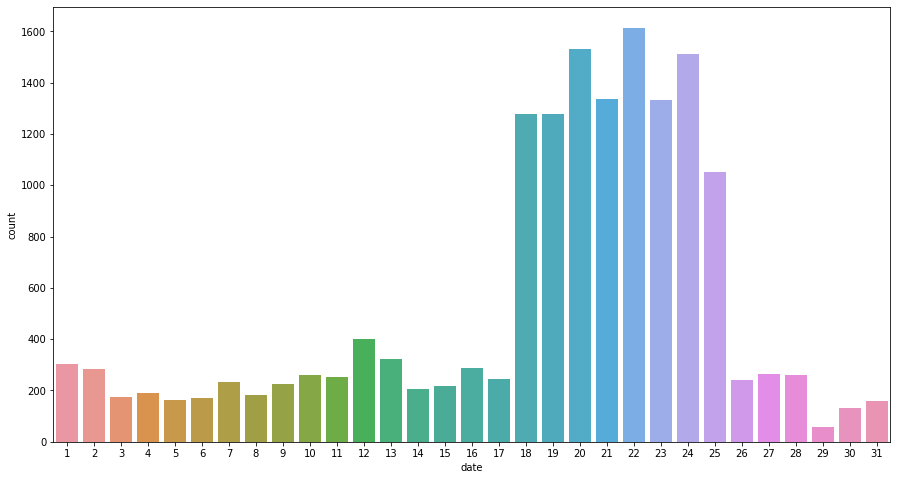

In [10]:
def plot_days(df):
    days_list=df["date"].apply(lambda x: int(re.search(r"-\d+$", x).group().replace('-','').replace('$','')))
    plt.figure(figsize = (15,8))
    sns.countplot(x=days_list.sort_values())
    plt.show()
    
plot_days(df)

## preprocessing

In [11]:
def preprocess_df(df):
    word_Lemmatized = WordNetLemmatizer()

    def preprocess(text):
        lower = text.lower()
        # Tokenization
        tokens = word_tokenize(lower)
        # Remove Stop words, Non-Numeric and perform Word Stemming/Lemmenting.
        # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
        tag_map = defaultdict(lambda : wn.NOUN)
        tag_map['J'] = wn.ADJ
        tag_map['V'] = wn.VERB
        tag_map['R'] = wn.ADV 
        Final_words = []
        for word, tag in pos_tag(tokens):
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        return Final_words
    
    df["preprocessed"] = df["text"].apply(preprocess)

preprocess_df(df)
df.head()  

,_id,date,time,text,preprocessed
0,6266bc14d13f89484f3999c9,2022-04-25,18:10:06,great fairy cosplay(oot) I'm new but happy wit...,"[great, fairy, cosplay, oot, new, happy, resul..."
1,6266bc14d13f89484f3999ca,2022-04-25,18:09:37,Ohhh🤣! This is me. And this is my friend........,"[friend, happyendingmassage, happyfarewell, ha..."
2,6266bc14d13f89484f3999cb,2022-04-25,18:07:28,#happy #PenguinDay Explorar para comprender y...,"[happy, penguinday, explorar, para, comprender..."
3,6266bc14d13f89484f3999cc,2022-04-25,18:06:35,hinagon_chan ゆうべは彼の部屋にお泊まり💓 #彼氏のいる生活 #のろけぐらむ❤︎...,"[彼氏のいる生活, loveyou, インテリア, カップルさんと繋がりたい, 料理上手な彼..."
4,6266bc14d13f89484f3999cd,2022-04-25,18:05:52,#happy #bankholidaymonday #buonventicinque 🍻 @...,"[happy, bankholidaymonday, buonventicinque, to..."


### Checking sentiment with nltk's pretrained analyzer

[Text(0, 0, 'negative'), Text(1, 0, 'positive')]

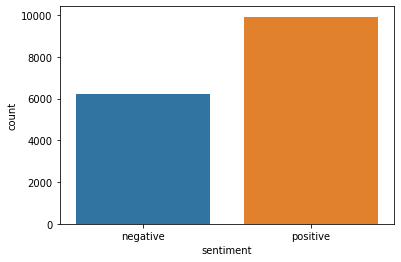

In [12]:
def get_sentiment(df):
    sia = SentimentIntensityAnalyzer()

    def is_positive(text):
        """True if text has positive compound sentiment, False otherwise."""
        return sia.polarity_scores(text)["compound"] > 0

    df["sentiment"] = df["text"].apply(is_positive)

    
get_sentiment(df)
ax = sns.countplot(x="sentiment", data=df)
ax.set_xticklabels(["negative","positive"])

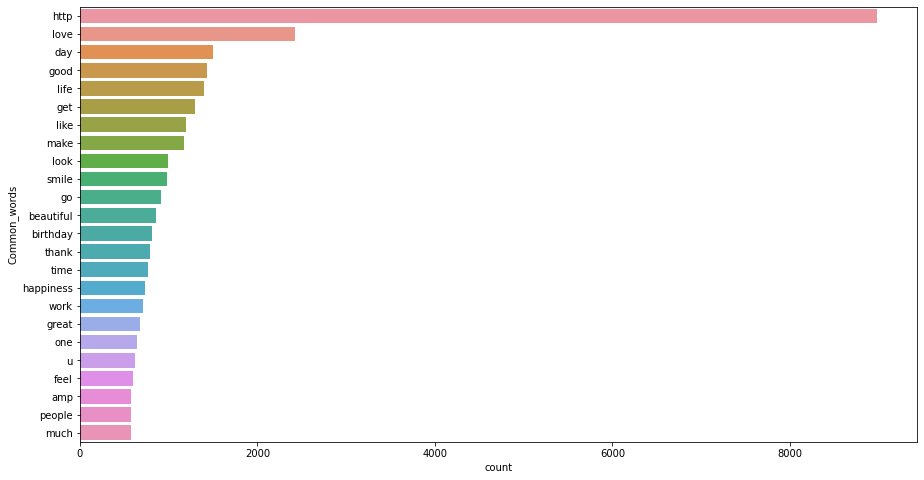

In [13]:
def plot_25_most_common_words(df):
    top = Counter([item for sublist in df['preprocessed'] for item in sublist])
    temp = pd.DataFrame(top.most_common(25))
    temp = temp.iloc[1:,:]
    temp.columns = ['Common_words','count']

    plt.figure(figsize = (15,8))
    sns.barplot(data=temp, x="count", y="Common_words")
    
    
plot_25_most_common_words(df)

### common word with positive sentiment

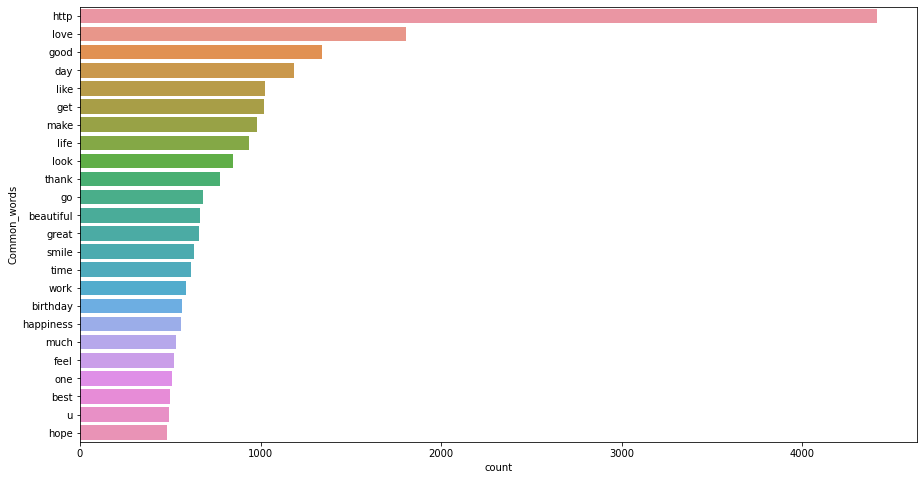

In [14]:
plot_25_most_common_words(df[df['sentiment']==True])

### common word with negative sentiment

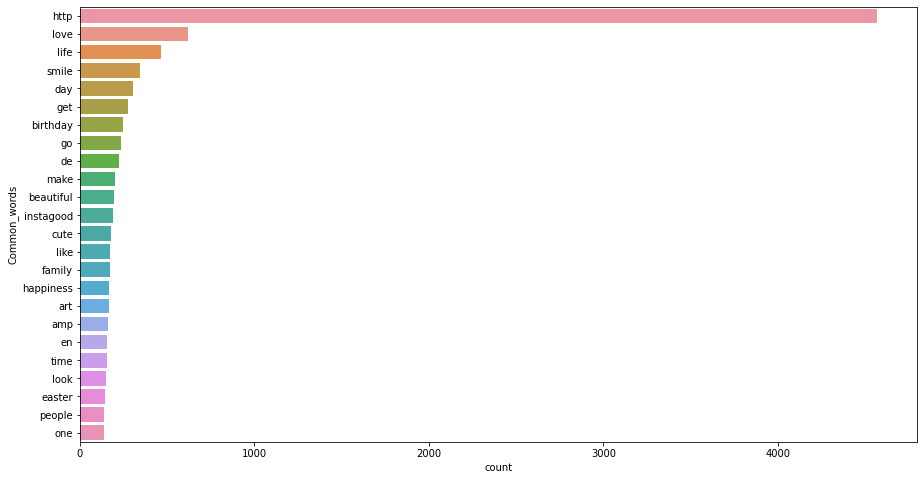

In [15]:
plot_25_most_common_words(df[df['sentiment']==False])

### Word cloud

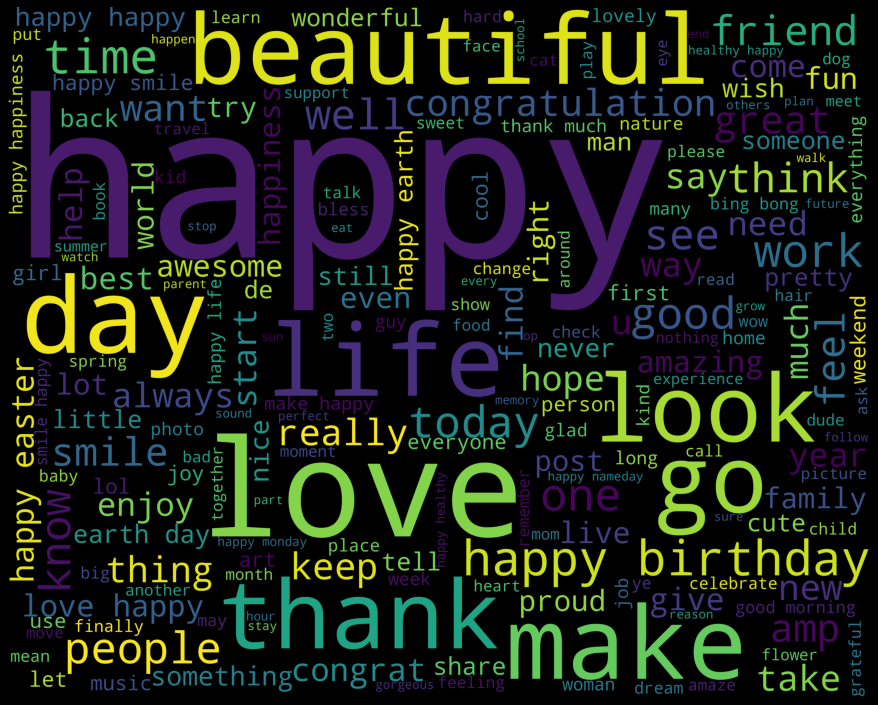

In [16]:
STOPWORDS.add('https')  # adding http to the stopwords, looks like a lot of #happy tweets and r/happy include links

def PlotWordCloud(list_of_list_of_tokens):
    all_text = ' '
    stopwords = set(STOPWORDS) 
    for token_list in list_of_list_of_tokens:
        for token in token_list:
            all_text = all_text + token + ' '

    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(all_text) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

PlotWordCloud(df["preprocessed"])